There has been significant buzz in the NBA about teams practicing with a 4-point line in their gyms. They are doing this to spread the floor and create more opportunities on offence. Additionally, the Big3 has introduced 4-point shots in specific circles on the court. While I don't think that a 4-point line will ever be introduced into the NBA, it is a fun exercise to see where the numbers suggest that it should be placed on the court. 

In my previous analysis I look at how far I believe that the 3-point line should actually be from the hoop: https://www.kaggle.com/kjeeone/how-far-should-the-3-point-line-actually-be. In this one, I evalaute a similar question related to a fabricated 4-point line. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nba-shot-logs/shot_logs.csv


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
df = pd.read_csv('/kaggle/input/nba-shot-logs/shot_logs.csv')

In [4]:
make_pct_pps_dist = pd.pivot_table(df, index='SHOT_DIST', values = ['FGM','PTS'] ).reset_index()
make_pct_dist = pd.pivot_table(df, index='SHOT_DIST', values = ['FGM'] ).reset_index()
make_pct_dist_cnt = pd.pivot_table(df, index='SHOT_DIST', values = ['FGM'], aggfunc='count' ).reset_index()

In [5]:
make_pct_dist_cnt.columns = ['SHOT_DIST','SHOT_COUNT']

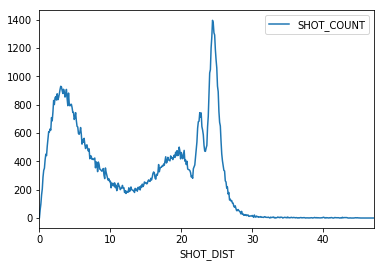

In [6]:
make_pct_dist_cnt.plot.line(x='SHOT_DIST')

In the graph above, we plot the number of shots by distance on the court. As you can see, there are more shots just outside of 3-point range taken than any other unique shots on the court. 

* The first spike of volume is near the rim where the points per shot are relatively high. 
* I expect that the second spike are unguarded shots from mid range. 
* The third spike is right outside of 22' where the 3-point line comes in on the corners
* The final spike is at 24.4' just a few inches into 3-point range

From this, we expect that there would be a similar spike in volume around a 4-point line. For this analysis, the raw volume does not matter, we care about the % volume to get points per shot. For simplicity,I will use the same distribution for 4-point shots as we do for 3-point shots. 

In [7]:
threes = make_pct_dist_cnt[make_pct_dist_cnt['SHOT_DIST'] > 23.75]
total_threes = threes.SHOT_COUNT.sum()
threes['shot_pct'] = threes.SHOT_COUNT / total_threes

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We can get % of shots taken from each incremental step outside of 3-point range. For the purposes of this analysis, we will assume the % volumes for a 4-point line will be the same by distance. 

(In reality, I expect the distribution would have a smaller shot distribution leading to more shots from very close to the 4-point line)

In [8]:
threes.head()

,SHOT_DIST,SHOT_COUNT,shot_pct
238,23.8,719,0.028983
239,23.9,863,0.034787
240,24.0,1024,0.041277
241,24.1,1048,0.042244
242,24.2,1201,0.048412


For our analysis, we will simply add a number to all of the 3-point shot distances to make push them past where our fabricated 4-point line would be. For example, if we wanted to see what a 28.75' 4 point line would look like, we would add 5' to all of the three point values. 

This takes into account the % quantity of shots taken by distance. 

Next we have to predict the shot make probability by distance. I use a simple logistic regression to do this. The regression uses makes and misses (1,0) as the dependent variable and distance from the rim as the independent variable. 

In [9]:
from sklearn.linear_model import LogisticRegression

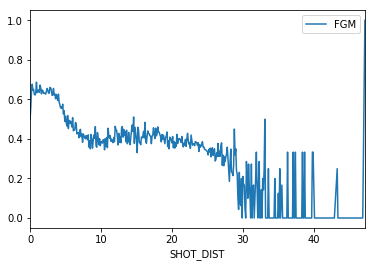

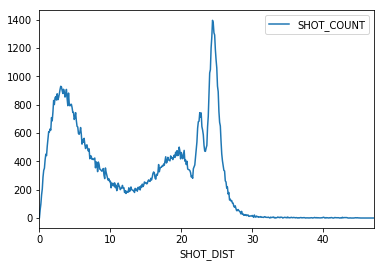

In [10]:
make_pct_dist.plot.line(x='SHOT_DIST')
make_pct_dist_cnt.plot.line(x='SHOT_DIST')

The above graph shows FGM % by distance. There is a clear downward trend starting at around 22'. We also see that the samples after around 27.5 feet get very small. Our goal is to project make probability past this mark. 

I believe that a model trained on only long jumpers (starting at 22') would be most representitive of 4-point jumpers. I trained the logistic regression with this model. 


In [11]:
three_range = df[df.SHOT_DIST > 22]
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(three_range.SHOT_DIST.values.reshape(-1, 1),three_range.FGM.values.reshape(-1, 1))
print('Score: ',log_reg.score(three_range.SHOT_DIST.values.reshape(-1, 1),three_range.FGM.values.reshape(-1, 1)))

Score:  0.6488711060302944


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
predicted_fgm_pct = log_reg.predict_proba(np.array(24).reshape(1,-1))
actual_fgm_pct = float(make_pct_dist[make_pct_dist['SHOT_DIST'] == 24].FGM)
print('predicted: ', predicted_fgm_pct[0][1], ' actual: ',actual_fgm_pct)

predicted:  0.36410120935183987  actual:  0.3583984375


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

makepcts = make_pct_dist[(make_pct_dist.SHOT_DIST >= 22) & (make_pct_dist.SHOT_DIST <= 27.3)]
ypred = log_reg.predict_proba(makepcts.SHOT_DIST.values.reshape(-1,1))
ypred[:,1]
print('RMSE: ',sqrt(mean_squared_error(makepcts.FGM,ypred[:,1])))
print('MAE: ',mean_absolute_error(makepcts.FGM,ypred[:,1]))

RMSE:  0.027429007209340134
MAE:  0.019903718674985246


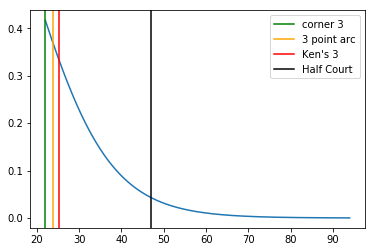

In [14]:
log_reg_curve = [log_reg.predict_proba(np.array(i/10).reshape(1,-1))[0][1] for i in range(220,940)]
plt.plot([i/10 for i in range(220,940)], log_reg_curve)
plt.axvline(x=22, label = 'corner 3', color = 'green')
plt.axvline(x=23.75, label = '3 point arc', color = 'orange')
plt.axvline(x=25.2, label = "Ken's 3", color = 'red')
plt.axvline(x=47, label = "Half Court", color = 'black')
plt.legend()


This graph shows our projected make % by distance over the length of the court. 

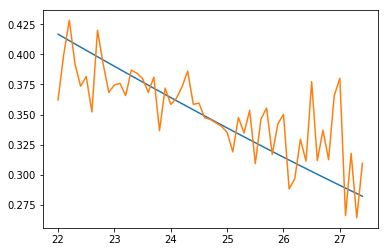

In [15]:
log_reg_curve = [log_reg.predict_proba(np.array(i/10).reshape(-1,1))[0][1] for i in range(220,275)]
actual_fgm_pct = [float(make_pct_dist[make_pct_dist['SHOT_DIST'] == i/10].FGM) for i in range(220,275)]
plt.plot([i/10 for i in range(220,275)], log_reg_curve)
plt.plot([i/10 for i in range(220,275)], actual_fgm_pct)


This graph shows projected vs actual make percent by distance. There is a clear downward trend, however there is obviously a lot of noise in the real data. 

Now we get to do the fun stuff, we get to project where the actual 4 point line should be. Again, we do this by setting the points per shot of the 4-point shots equal to those of 3-pointers and 2-pointers. 

To get points per shot for 4-pointers we use the following equation: 
    points_per_shot_from_range = (% of shots from certain range) x (make % from that range)
    next we sum(points_per_shot_from_range) for all 4-point shots. 
    
We want to set the points per shot = ~.9 (as seen in my 3-point line analysis)


In [16]:
ken_threes = threes.copy()
ken_threes['SHOT_DIST'] = ken_threes.SHOT_DIST.apply(lambda x: x+1.45)
ken_threes['shot_pct'] = ken_threes.SHOT_COUNT / ken_threes.SHOT_COUNT.sum()

In [17]:
ken_threes['proj_make_pct'] = ken_threes.SHOT_DIST.apply(lambda x: log_reg.predict_proba(np.array(x).reshape(-1,1))[0][1])

In [18]:
ken_threes['pps'] = ken_threes.shot_pct*ken_threes.proj_make_pct*3

In [19]:
ken_threes.pps.sum()

0.8978327909270424

Our new model is slightly off from the real data, about 2%. I believe that this is still good enough to extrapolate upon. The real data suggests that the points per shot equilibrium is ~.92, our model slightly under predicts at ~.90. 

We will still use .92 as our benchmark. 

Now let's evaluate the 4-point, points per shot using the 3 point distribution. We simply add the number to all of our metrics to get the starting point.

In [20]:
def pps_fpoint(three_distribution, size, pps_benchmark):
    new_distribution = three_distribution
    plot_data = []
    closest = ''
    diff = 1000
    for i in range(1,size*10):
        new_distribution.SHOT_DIST = new_distribution.SHOT_DIST.apply(lambda x: x + (i/10))
        new_distribution['proj_make_pct'] = new_distribution.SHOT_DIST.apply(lambda x: log_reg.predict_proba(np.array(x).reshape(-1,1))[0][1])
        new_distribution['pps'] = new_distribution.shot_pct*new_distribution.proj_make_pct*4
        points_per_shot = new_distribution.pps.sum()
        plot_data.append((25.2+i/10,points_per_shot))
        if abs(points_per_shot - pps_benchmark) < diff:
            closest = str(25.2+i/10)
            diff = abs(points_per_shot - pps_benchmark)
    return (closest,diff,points_per_shot), plot_data
        
        
        

In [21]:
closest, four_pt_dist = pps_fpoint(ken_threes,30,.92)

In [22]:
closest

('26.0', 0.027131899445961838, 5.125449052967697e-216)

In [23]:
four_pt_dist

[(25.3, 1.1879036519186017),
 (25.4, 1.1696123960930862),
 (25.5, 1.142485194542291),
 (25.599999999999998, 1.106904487320991),
 (25.7, 1.0633959142694518),
 (25.8, 1.012637215916498),
 (25.9, 0.9554638469600484),
 (26.0, 0.8928681005540382),
 (26.099999999999998, 0.825988603338868),
 (26.2, 0.7560876685940723),
 (26.3, 0.6845152772242178),
 (26.4, 0.6126603415454046),
 (26.5, 0.5418921485804711),
 (26.599999999999998, 0.4734970412586294),
 (26.7, 0.4086169386084344),
 (26.8, 0.34819674003593065),
 (26.9, 0.29294676483796867),
 (27.0, 0.24332426629445703),
 (27.099999999999998, 0.19953519953348778),
 (27.2, 0.1615544859523288),
 (27.3, 0.12916065631865226),
 (27.4, 0.10197940151879555),
 (27.5, 0.07953032813211991),
 (27.599999999999998, 0.061271928821889206),
 (27.7, 0.046641082970282285),
 (27.8, 0.03508491301776494),
 (27.9, 0.026084220263118036),
 (28.0, 0.019168817327247505),
 (28.099999999999998, 0.013925793086112968),
 (28.2, 0.010002111503353905),
 (28.3, 0.0071030316391167345)

It looks like the model that I built actually projects a 4-point line to only be a few inches back from where my 3-point line was at 26' even. There is a relatively steep drop-off as we get incrementally further from the rim. 

Most of the other analysis I look at only takes into account shots right at the 3 point or 4 point line. This evaluates for all shots beyond that point. 
